In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

from google.colab import drive
drive.mount('/content/drive')
PROJECT_ROOT = '/content/drive/My Drive/d2d_channelprediction'
%mkdir '/content/drive/My Drive/d2d_channelprediction' -p
%cd '/content/drive/My Drive/d2d_channelprediction'
DATASETS_PATH = "data"
WORKING_PATH = "."
%mkdir $DATASETS_PATH -p

LOGDIR = f"{WORKING_PATH}/logs"
MODEL_VERSION = 'TEST'

Mounted at /content/drive
/content/drive/My Drive/d2d_channelprediction


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Dict, NamedTuple, Union
from tqdm.notebook import tqdm
import logging
from matplotlib import pyplot as plt
import time
from itertools import product
import gc
import pathlib
from glob import glob

from dateutil.relativedelta import relativedelta

In [113]:
HORIZON = 12

los_indoor = pd.read_csv('/content/drive/MyDrive/d2d_channelprediction/data/fast_fading_dB_LOS_Head_Indoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T
los_outdoor = pd.read_csv('/content/drive/MyDrive/d2d_channelprediction/data/fast_fading_dB_LOS_Head_Outdoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T
nlos_indoor = pd.read_csv('/content/drive/MyDrive/d2d_channelprediction/data/fast_fading_dB_NLOS_Head_Indoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T
nlos_outdoor = pd.read_csv('/content/drive/MyDrive/d2d_channelprediction/data/fast_fading_dB_NLOS_Head_Outdoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T

train_los_indoor = los_indoor[0:int(len(los_indoor) - HORIZON)]
test_los_indoor = los_indoor[-int(HORIZON):].reset_index(drop=True)

train_los_outdoor = los_outdoor[0:int(len(los_outdoor) - HORIZON)]
test_los_outdoor = los_outdoor[-int(HORIZON):].reset_index(drop=True)

train_nlos_indoor = nlos_indoor[0:int(len(nlos_indoor) - HORIZON)]
test_nlos_indoor = nlos_indoor[-int(HORIZON):].reset_index(drop=True)

train_nlos_outdoor = nlos_outdoor[0:int(len(nlos_outdoor) - HORIZON)]
test_nlos_outdoor = nlos_outdoor[-int(HORIZON):].reset_index(drop=True)

train_dataset = pd.concat([train_los_indoor, train_los_outdoor, train_nlos_indoor, train_nlos_outdoor], axis=1).T.reset_index(drop=True)
test_dataset = pd.concat([test_los_indoor, test_los_outdoor, test_nlos_indoor, test_nlos_outdoor], axis = 1).T.reset_index(drop=True)

train_dataset.to_csv('/content/drive/MyDrive/d2d_channelprediction/data/train_d2d.csv', encoding='utf-8')
test_dataset.to_csv('/content/drive/MyDrive/d2d_channelprediction/data/test_d2d.csv', encoding='utf-8')

### 0: 

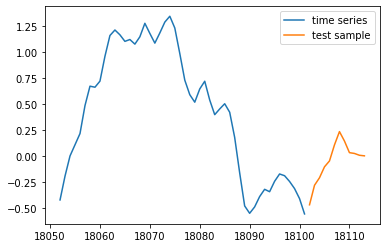

In [125]:
nsamples = 50
plt.plot(train_los_indoor[-nsamples:], label='time series')
plt.plot(np.concatenate([np.nan*np.zeros(len(train_los_indoor)), test_los_indoor[0]]), label='test sample')
plt.legend();

### 1:

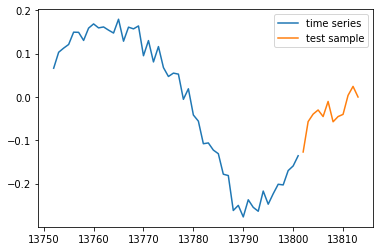

In [126]:
nsamples = 50
plt.plot(train_los_outdoor[-nsamples:], label='time series')
plt.plot(np.concatenate([np.nan*np.zeros(len(train_los_outdoor)), test_los_outdoor[0]]), label='test sample')
plt.legend();

### 2:

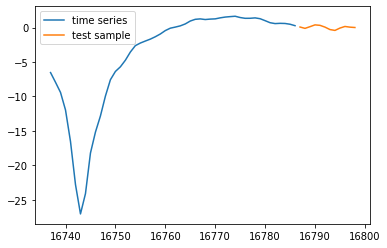

In [127]:
nsamples = 50
plt.plot(train_nlos_indoor[-nsamples:], label='time series')
plt.plot(np.concatenate([np.nan*np.zeros(len(train_nlos_indoor)), test_nlos_indoor[0]]), label='test sample')
plt.legend();

### 3:

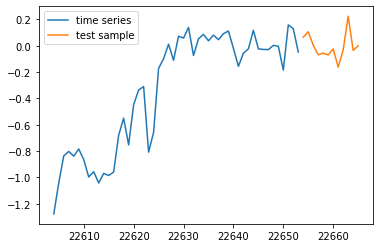

In [128]:
nsamples = 50
plt.plot(train_nlos_outdoor[-nsamples:], label='time series')
plt.plot(np.concatenate([np.nan*np.zeros(len(train_nlos_outdoor)), test_nlos_outdoor[0]]), label='test sample')
plt.legend();